I've been working on stock data without normaization. The essense of stock data would be the ration value between current and previous. Let's try it out!

In [76]:
!pip install matplotlib --upgrade

Requirement already up-to-date: matplotlib in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy>=1.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pytz in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: cycler in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.4,>=1.5.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Cleaning up...


In [77]:
#generic
%matplotlib inline
from __future__ import print_function

#public open pakcages and methods
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#private pakcages and methods
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter

#for testing
from IPython import display
import platform
import time

In [78]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    for d in data_it:
        return_data.append(d[key])
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data = []
    date = []
    for share in share_list:
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data.append(map(float, get_data_by_key(key=data_type, data=hist_data)))
        date.append(get_data_by_key(key='Date', data=hist_data))
    return np.array(stock_data).T, date

In [79]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data_pred, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

In [80]:
class ESN(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, 
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        # use log ratio data
        df_input = input_data[1:] / input_data[:-1]
        df_target = target_data[1:] / target_data[:-1]
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]])\
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[1.0, df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
            
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), df_input, middle_data]
        accumulated_price = np.cumprod(np.dot(self.W_out, pre_out[start_time:].T).T)
        learned_data = target_data[start_time] * np.r_[1.0, accumulated_price]
        return np.r_[target_data[0][:start_time], learned_data]
    
    def predict(self, input_data, sig=0):
        df_input = input_data[1:] / input_data[:-1]
        output_data = []
        N_data = len(df_input)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[1.0, df_input[i], new_m])
            middle = new_m
            output_data.append(output)
        output_data = np.array(output_data).T[0]
        accumulated_price = np.cumprod(output_data)
        return np.r_[1.0, accumulated_price]

learning_time: 0.123296022415


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:109: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


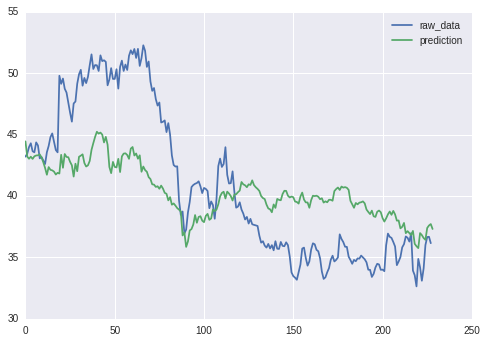

In [26]:
import time

T = len(input_data)
N_middle = T 
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-3)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0396208763123


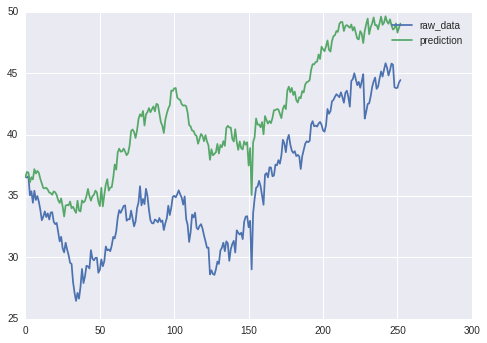

In [9]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 6.89499688148


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:109: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


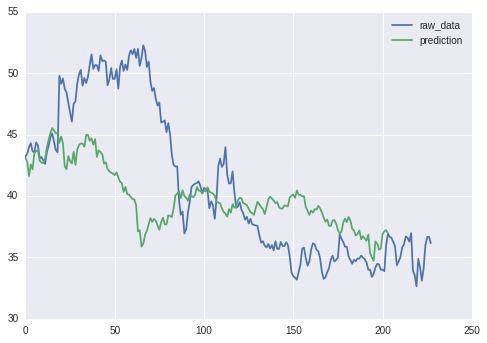

In [12]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-3)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data[start_time:], label="prediction")
plt.legend()

prediction time: 0.596215009689


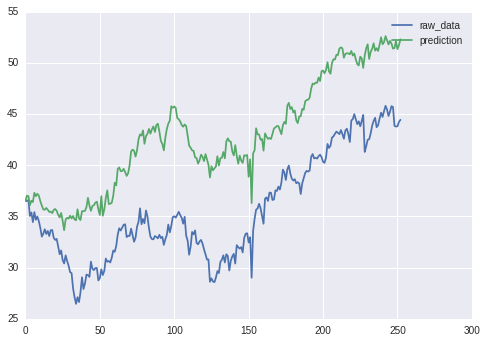

In [13]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

In [104]:
class ESN2(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, 
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        # use log ratio data
        df_input = np.log(input_data[1:] / input_data[:-1])
        df_target = np.log(target_data[1:] / target_data[:-1])
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]])\
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[1.0, df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
           
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), df_input, middle_data]
        accumulated_price = np.cumprod(np.exp(np.dot(self.W_out, pre_out[start_time:].T).T))
        learned_data = target_data[start_time][0] * np.r_[1.0, accumulated_price]
        return learned_data
    
    def predict(self, input_data, sig=0):
        df_input = np.log(input_data[1:] / input_data[:-1])
        output_data = []
        N_data = len(df_input)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[1.0, df_input[i], new_m])
            middle = new_m
            output_data.append(output)
        output_data = np.exp(np.array(output_data).T[0])
        accumulated_price = np.cumprod(output_data)
        return np.r_[1.0, accumulated_price]

learning_time: 0.123766899109


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


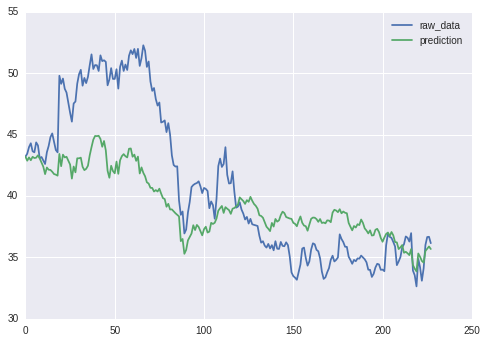

In [33]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-3)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0402369499207


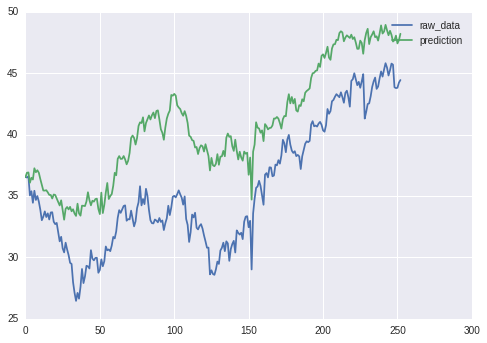

In [34]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 6.88251399994


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


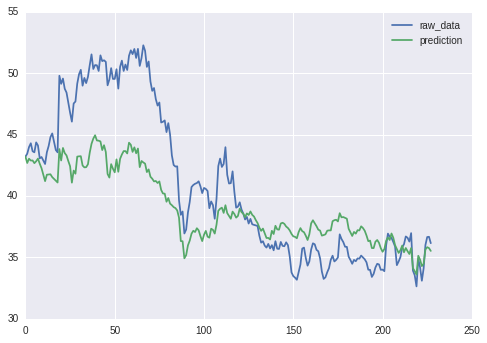

In [35]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-3)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.590700149536


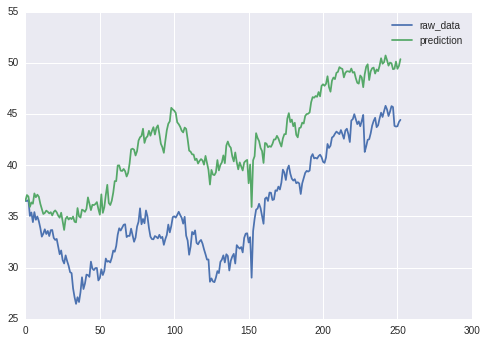

In [36]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# change the noise

learning_time: 0.122200012207


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


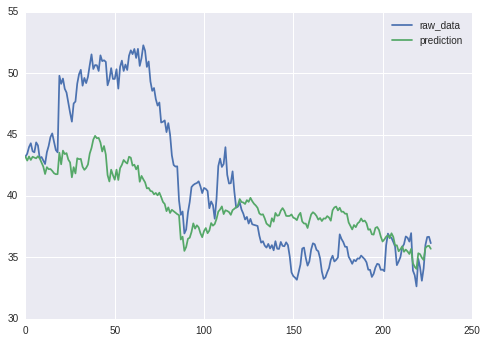

In [47]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=0)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0398271083832


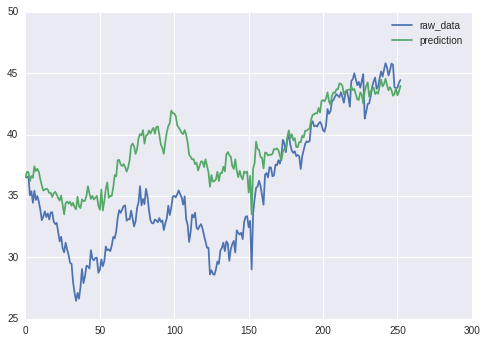

In [48]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 0.122453212738


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


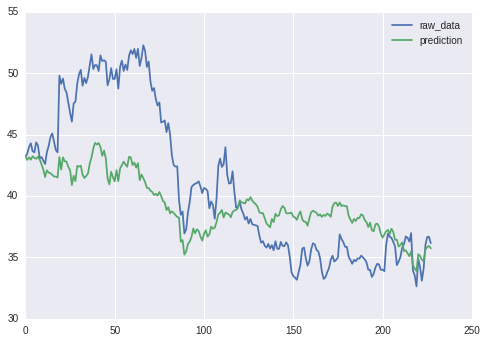

In [49]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-4)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0408978462219


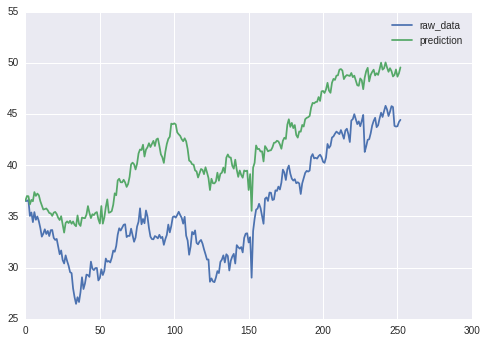

In [50]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 0.124672889709


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


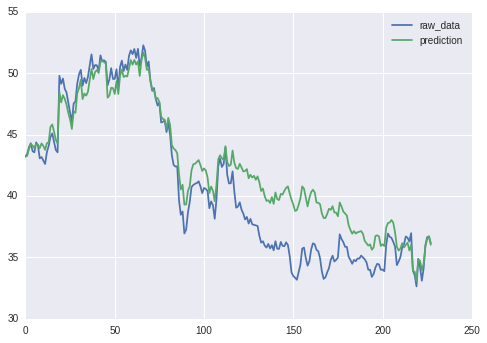

In [51]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0397500991821


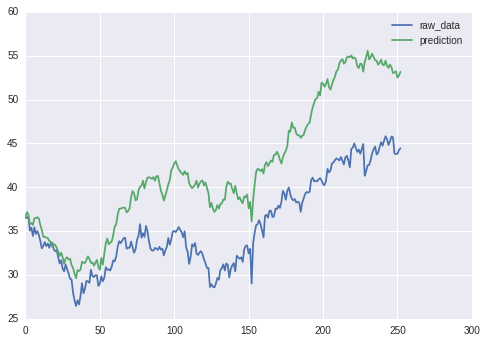

In [52]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 0.12825512886


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


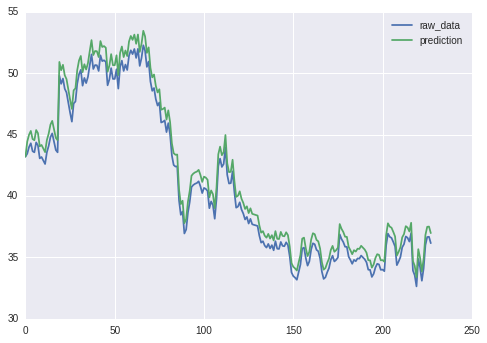

In [53]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0407161712646


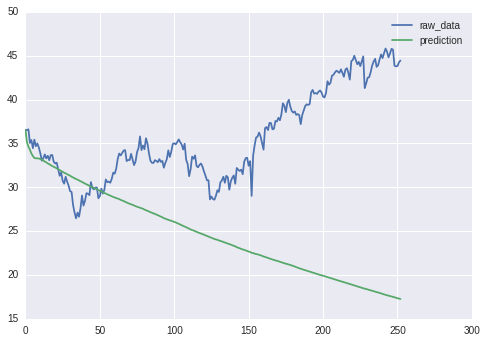

In [54]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 0.123860120773


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


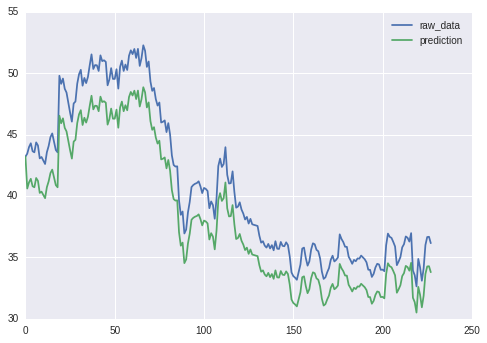

In [55]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=10)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0411930084229


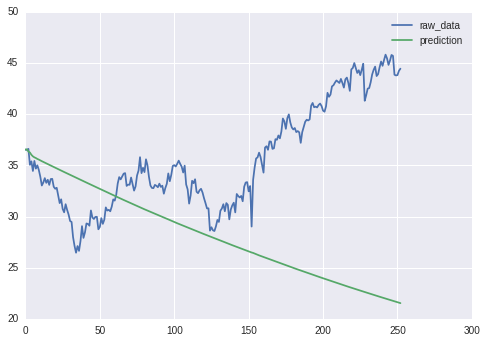

In [56]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

We are going to work with sig=1.0e-2

# Let's explore more data!

In [57]:
target_list = ['YHOO']

input_list = ["AAPL", "ORCL", "IBM", "INTC"]
energy = ["PTR", "XOM", "CVX", "RDS-A"]
financial = ["WFC", "JPM", "HSBC", "BAC"]
healthcare = ["NVX", "PFE", "MRK"]
hardware = ["AAPL", "ORCL", "IBM", "INTC"]
software = ["MSFT", "GOOGL", "FB"]
input_list = energy + financial + healthcare + hardware + software

In [58]:
start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data_pred, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

learning_time: 0.137263774872


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


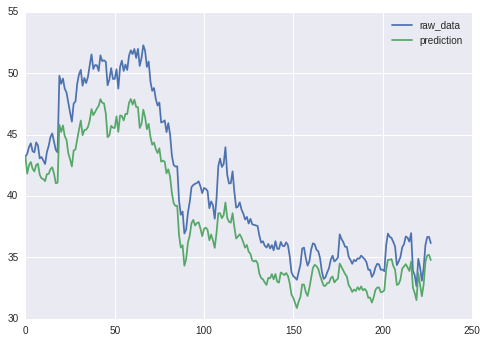

In [59]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0430209636688


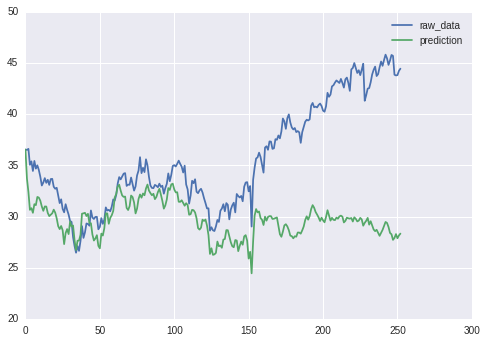

In [60]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 7.16758489609


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


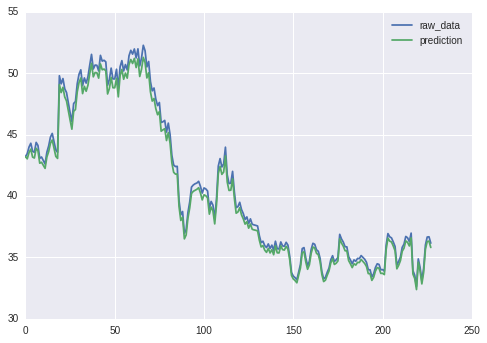

In [61]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.600311994553


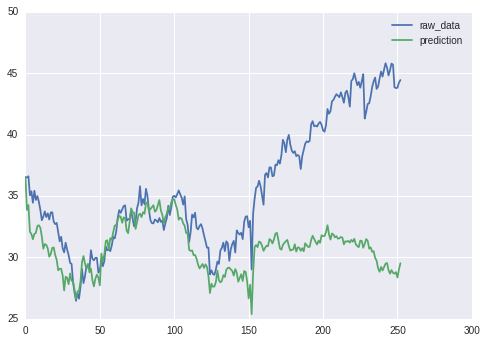

In [62]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 48.6164629459


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


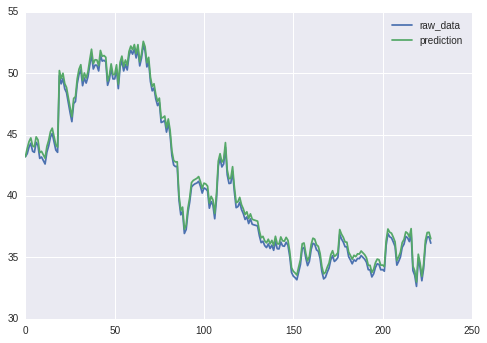

In [63]:
import time

T = len(input_data)
N_middle = T * 10
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.21898818016


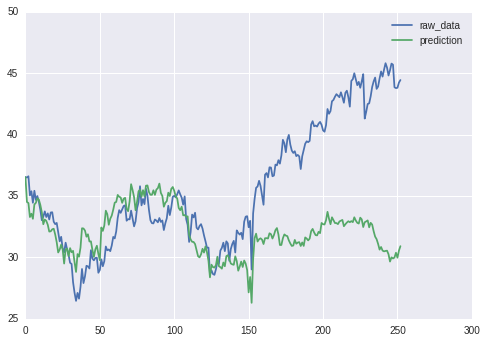

In [64]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Some Other Models

# Model with Feedback

In [99]:
class ESN3(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh,
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None, W_fb=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        if W_out is None:
            # the number of non-zero elements
            num_w = int(N_out * (N_middle + N_in)  * dense)
            W_out = np.zeros(shape=(N_out, N_middle + N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_out)
                col = np.random.randint(low=0, high=N_middle + N_in)
                while(W_out[row][col] != 0):
                    row = np.random.randint(low=0, high=N_out)
                    col = np.random.randint(low=0, high=N_middle + N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_out[row][col] = u
            # bias
            num_b = int(N_out  * dense)
            bias_out = np.zeros(shape=N_out)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_out)
                while(bias_out[row] != 0):
                    row = np.random.randint(low=0, high=N_out)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_out[row] = u
            W_out = np.c_[bias_out, W_out]
        self.W_out = W_out
        
        if W_fb is None:
            # the number of non-zero elements
            num_w = int(N_out * N_middle  * dense)
            W_fb = np.zeros(shape=(N_middle, N_out))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_out)
                while(W_fb[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_out)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_fb[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_fb = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_fb[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_fb[row] = u
            W_fb = np.c_[bias_fb, W_fb]
        self.W_fb = W_fb     
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        df_input = np.log(input_data[1:] / input_data[:-1])
        df_target = np.log(target_data[1:] / target_data[:-1])
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                + np.dot(self.W_middle, middle)\
                + np.dot(self.W_fb, np.r_[1.0, output])
                )\
                + sig*np.random.randn(self.N_middle)
                
            new_o = np.dot(self.W_out, np.r_[1.0, df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
            output = new_o
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[1.0, df_input[i], new_m])
            
                Y_tilde = np.array(Y)
                X_tilde = np.array(X)
                                    
                if L2 == 0:
                    X_inv = np.real(np.linalg.pinv(X_tilde.T))
                else:
                    X_inv = np.dot(X_tilde, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1)\
                            + np.dot(X_tilde.T, X_tilde)
                        )
                    )
                self.W_out = np.dot(Y_tilde.T, X_inv)
        
        #keep middle, output data for predcition
        self.middle = middle
        self.output = output
        pre_out = np.c_[np.ones(N_data - start_time), 
                        df_input[start_time:], middle_data[start_time:]]
       
        ret = target_data[start_time] * np.r_[1.0, np.cumprod(np.exp(np.dot(self.W_out, pre_out.T).T))]
        return np.r_[target_data[:start_time][0], ret]
    
    def predict(self, input_data, sig=0):
        df_input = np.log(input_data[1:] / input_data[:-1])
        output_data = []
        N_data = len(df_input)
        #initalization
        middle = self.middle
        output = self.output
        for i in xrange(N_data):
            middle = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                + np.dot(self.W_middle, middle)\
                + np.dot(self.W_fb, np.r_[1.0, output])
                )\
                + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[1.0, df_input[i], middle])
            output_data.append(output[0])
        ret = np.cumprod(np.r_[1.0, np.exp(np.array(output_data))])   
        return ret

learning_time: 14.4960949421


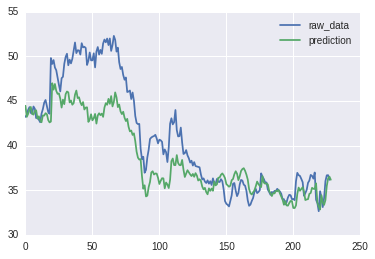

In [100]:
import time

T = len(input_data)
N_middle = T 
esn = ESN3(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = int(0.1 * T)


st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0413999557495


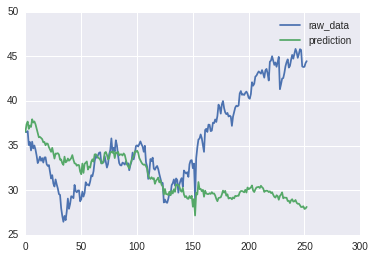

In [101]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 1278.47910595


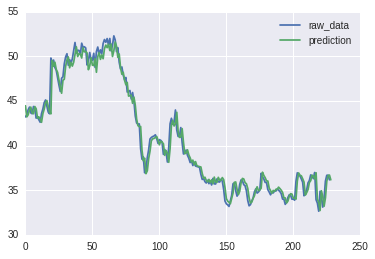

In [102]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN3(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = int(0.1 * T)


st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.55882692337


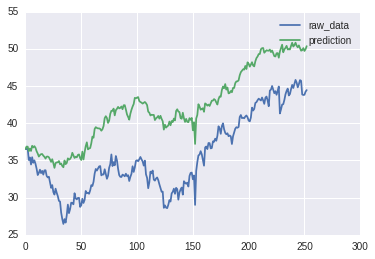

In [103]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

Though Model with feedback takes a lot of time to learn, it deosn't seem improving the accuracy.

Let's work on model without feedback!

The best performance architecture is a model with sigma 1.0e-2

learning_time: 6.71584701538


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


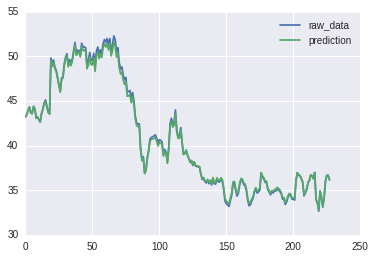

In [109]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.555788040161


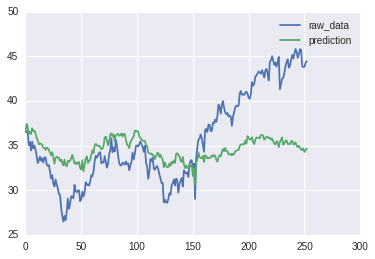

In [110]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

In [111]:
target_list = ['YHOO']
input_list = ["AAPL", "ORCL", "IBM", "INTC"]

start_date="2013-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data_pred, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 

learning_time: 50.48873806


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


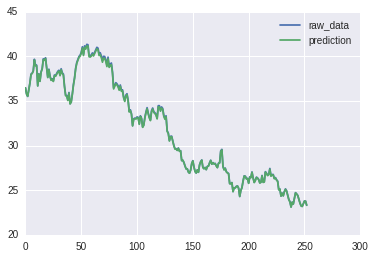

In [112]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.18902492523


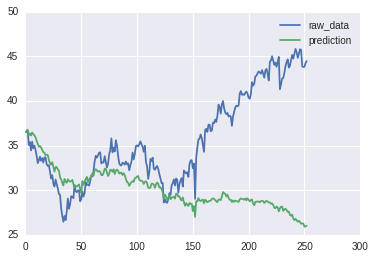

In [113]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Try with Normalization

In [114]:
class ESN4(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, 
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
    def normalization(self, data):
        dev = np.sqrt(np.var(data, axis=0))
        mean = np.mean(data, axis=0)
        return (data - mean) / dev, mean, dev
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        # use log ratio data
        df_input_tilde = np.log(input_data[1:] / input_data[:-1])
        df_input, mean_ipt, dev_ipt = self.normalization(df_input_tilde)
        df_target_tilde = np.log(target_data[1:] / target_data[:-1])
        df_target, mean_tgt, dev_tgt = self.normalization(df_target_tilde)
        #keep deviance and mean for prediction
        self.input_mean = mean_ipt
        self.input_dev = dev_ipt
        self.output_mean = mean_tgt
        self.output_dev = dev_tgt
        
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]])\
                + np.dot(self.W_middle, middle)
                )\
                + sig * np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[1.0, df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
           
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), df_input, middle_data]
        modified_out = self.output_dev * np.dot(self.W_out, pre_out[start_time:].T).T + self.output_mean
        accumulated_price = np.cumprod(np.exp(modified_out))
        learned_data = target_data[start_time] * np.r_[1.0, accumulated_price]
        return learned_data
    
    def predict(self, input_data, sig=0):
        df_input_tilde = np.log(input_data[1:] / input_data[:-1])
        df_input = (df_input_tilde - self.input_mean) / self.input_dev
        N_data = len(df_input)
        #initalization
        middle = self.middle.copy()
        output_data = []
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[1.0, df_input[i], new_m])
            middle = new_m
            output_data.append(output)
        output_data_tilde = np.exp((self.output_dev * np.array(output_data) + self.output_mean).T)
        accumulated_price = np.cumprod(output_data_tilde)
        return np.r_[1.0, accumulated_price]

learning_time: 50.513354063


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:120: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:122: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


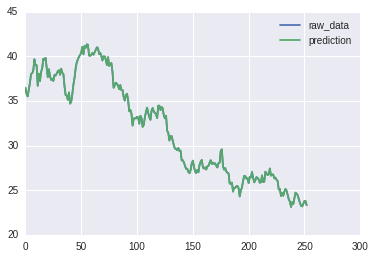

In [115]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN4(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data[0]))
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.20183396339


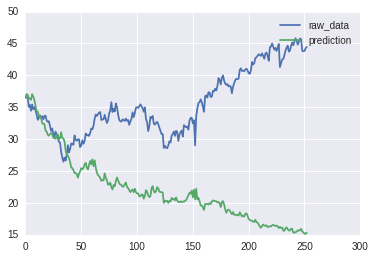

In [116]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Explore more data

In [131]:
energy = ["PTR", "XOM", "CVX", "RDS-A", "BP", "TOT", "SLB", "KMI", "COP", "CEO"]
financial = ["WFC", "JPM", "HSBC", "BAC", "C", "SAN", "MTU", "RY", "WBK", "TD"]
healthcare = ["NVS", "JNJ", "PFE", "MRK", "GILD", "SNY", "AMGN", "NVO", "GSK", "UNH"]
buisiness = ["ACN", "LMT", "CNI", "FDX", "DAL", "CSX", "AAL", "CP", "NSC", "NOC"]
telecom = ["CHL", "VZ", "T", "VOD", "NTT", "AMX", "CHA", "BT", "CHU", "ORAN"]
hardware = ["AAPL", "ORCL", "IBM", "INTC", "CSCO", "TSM", "QCOM", "HPQ", "TXN", "EMC"]
software = ["MSFT", "GOOGL", "FB", "BIDU", "EBAY", "SAP", "CRM", "VMW", "ADBE"]
industrial = ["GE", "V", "MA", "UTX", "MMM", "BA", "UNP", "UPS", "HON", "DHR"]
manufacturing = ["TM", "HMC", "F", "GM", "JCI", "TSLA", "TTM", "CMI", "DLPH", "MGA"]
consumer = ["PG", "BUD", "KO", "PEP", "UL", "PM", "BTI", "MO", "ABEV", "DEO"]
diversified = ["BRK-A", "BRK-B", "UTX", "BC", "RTN", "OLN", "ITT", "MSBHY", "KWHIY", "ABB"]
retailing = ["WMT", "AMZN", "HD", "MCD", "NKE", "SBUX", "CVS", "WBA", "PCLN", "COST"]

target_list = ["YHOO"]

input_list = energy + financial + healthcare + buisiness + telecom\
+ hardware + software + industrial + manufacturing + consumer + diversified + retailing

In [124]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    flag = True
    for d in data_it:
        return_data.append(d[key])
        
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data_list = []
    date = []
    flag = True
    N_data = 0
    for idx, share in enumerate(share_list):
        name = name_list[idx]
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data = map(float, get_data_by_key(key=data_type, data=hist_data))
        date.append(get_data_by_key(key='Date', data=hist_data))
        stock_data_list.append(stock_data)
        N_data = len(stock_data)
        assert N_data != 0, "%s data is broken" % name
        if idx != 0:
            assert pre_N_data == N_data, "%s data is broken" % name
        pre_N_data = N_data
    return np.array(stock_data_list).T, date

In [133]:
import time

st = time.time()
start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 
elapsed = time.time() - st
print ("time for getting training_data:", elapsed)

st = time.time()
start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
target_data_pred, date = get_data_by_list(target_list, start_date=start_date, end_date=end_date) 
elapsed = time.time() - st
print ("time for getting test_data:", elapsed)

learning_time: 0.257958173752


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


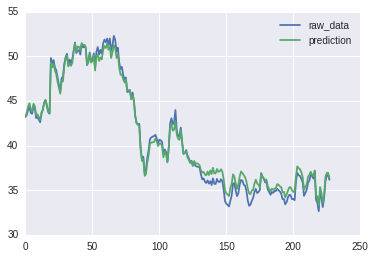

In [134]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0483219623566


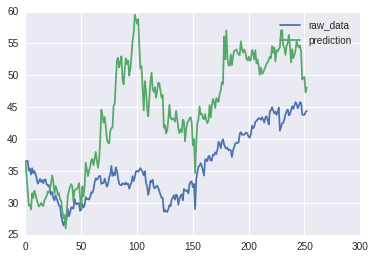

In [135]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 8.39089918137


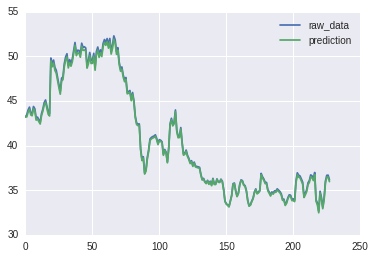

In [158]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.604969024658


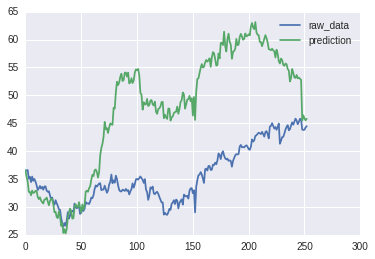

In [159]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Add More Data!

In [ ]:
energy = ["PTR", "XOM", "CVX", "RDS-A", "BP", "TOT", "SLB", "KMI", "COP", "CEO", 
          "E", "STO", "EDPR.LS", "OXY", "PBR", "EOG", "APC", "SU", "ENB", "PSX", "HAL", "WMB"]
financial = ["WFC", "JPM", "HSBC", "BAC", "C", "SAN", "MTU", "RY", "WBK", "TD", "GS", 
             "LYG", "AXP", "AIG", "MS", "ITUB", "BCS", "BBVA"]
healthcare = ["NVS", "JNJ", "PFE", "MRK", "GILD", "SNY", "AMGN", "NVO", "GSK", "UNH",
             "MDT", "BMY", "ABBV", "CELG", "BIIB", "AZN", "LLY", "ABT", "AGN", "VRX", "TEVA",
             "TMO", "SHPG", "REGN"]
buisiness = ["ACN", "LMT", "CNI", "FDX", "DAL", "CSX", "AAL", "CP", "NSC", "NOC", "LUV"]
telecom = ["CHL", "VZ", "T", "VOD", "NTT", "AMX", "CHA", "BT", "CHU", "ORAN", "BCE",
           "CHT", "SKM", "TI", "TU", "S", "TLK", "DUK", "NGG", "NEE", "D", "SO", "EXC", "KEP",
          "AEP", "SRE", "PCG", "HNP", "PPL", "PEG", "EIX", "ETP", "ED", "ENI", "XEL", "ES", "FE"]
hardware = ["AAPL", "ORCL", "IBM", "INTC", "CSCO", "TSM", "QCOM", "HPQ", "TXN", "EMC",
           "CAJ", "ASML", "ERIC", "SNE", "AVGO", "MU", "GLW", "BRCM", "NXPI", "NOK",
           "AMAT", "WDC", "WIT", "ADI", "STX", "APH"]
software = ["MSFT", "GOOGL", "FB", "BIDU", "EBAY", "SAP", "CRM", "VMW",
            "ADBE", "CTSH", "INFY", "INTU", "LNKD", "TWTR", "RHT", "NTES", "CHKP", 
            "CA", "ADSK", "AKAM", "NVDA"]
industrial = ["GE", "V", "MA", "UTX", "MMM", "BA", "UNP", "UPS", "HON", "DHR", "CAT", 
              "ABB", "GD", "ADP", "EMR", "ITW", "ECL", "PCP", "TEL", "PCAR", "WM"]
manufacturing = ["TM", "HMC", "F", "GM", "JCI", "TSLA", "TTM", "CMI", "DLPH", "MGA",
                "CMI", "DLPH", "MGA", "GPC", "BWA", "HOG", "ALV", "HAR", "LEA", "LKQ", 
                 "WBC", "GT", "FCAU", "NSANY", "VOW3.DE", "NAV", "005380.KS"]
consumer = ["PG", "BUD", "KO", "PEP", "UL", "PM", "BTI", "MO", "ABEV", "DEO", "MDLZ",
            "CL", "MON", "MCK", "KMB", "WHR", "DIS", "CMCSA", "FOXA", "TWX", "TWC",
           "DISH", "CBS", "DISCA", "TV", "CHTR", "LVNTA", "QVCA", "OMC", "NLSN", 
           "PSO", "LMCA", "SJR", "NFLX"]
diversified = ["BRK-A", "BRK-B", "UTX", "BC", "RTN", "OLN", "ITT", "MSBHY", "KWHIY", 
               "ABB", "IEP", "GE"]
retailing = ["WMT", "AMZN", "HD", "MCD", "NKE", "SBUX", "CVS", "WBA", "PCLN", "COST", 
            "TGT", "TJX", "LVS", "YUM", "CCL", "LUX", "DG", "M", "AZO", "ROST", "CMG", "GPS", 
            "DLTR", "RCL", "KSS", "HOT", "JWN"]

target_list = ['YHOO']

input_list = energy + financial + healthcare + buisiness + telecom\
+ hardware + software + industrial + manufacturing + consumer + diversified + retailing
print (len(input_list))

In [145]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    flag = True
    for d in data_it:
        return_data.append(d[key])
        
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data_list = []
    date = []
    flag = True
    N_data = 0
    fail_name_list = []
    for idx, share in enumerate(share_list):
        name = name_list[idx]
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data = map(float, get_data_by_key(key=data_type, data=hist_data))
        date.append(get_data_by_key(key='Date', data=hist_data))
        stock_data_list.append(stock_data)
        N_data = len(stock_data)
        if N_data == 0:
            fail_name_list.append(name)
    print ("fail_name_list: ", fail_name_list)
    return np.array(stock_data_list).T, date

learning_time: 0.260835886002


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


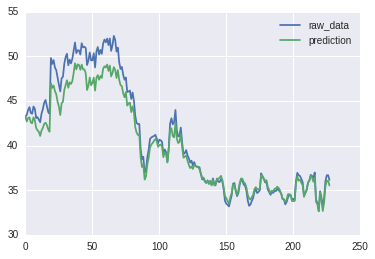

In [146]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0484609603882


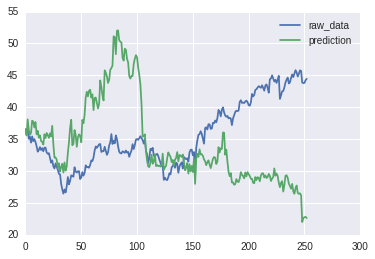

In [147]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.3931350708


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


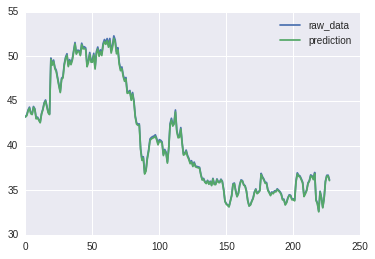

In [154]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.604846954346


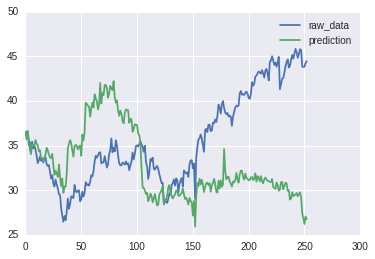

In [155]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Change eigen value scale

learning_time: 8.39754700661


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


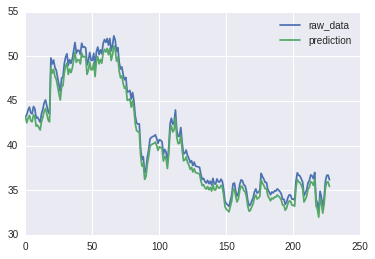

In [162]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.95, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.612338066101


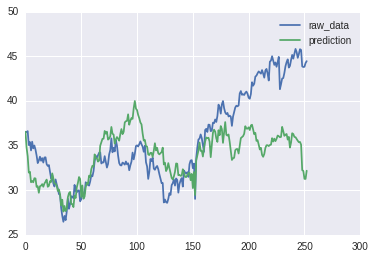

In [163]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.38904595375


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


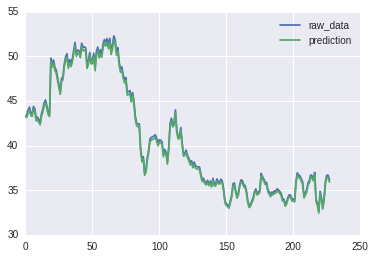

In [164]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.99, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.606240034103


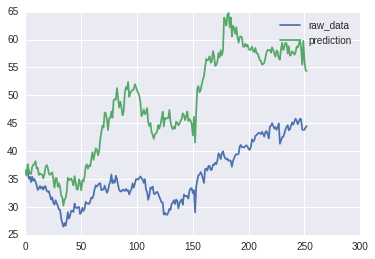

In [165]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.39522790909


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


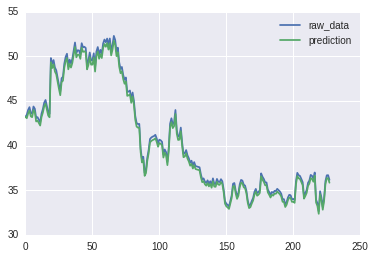

In [166]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.999, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.603417873383


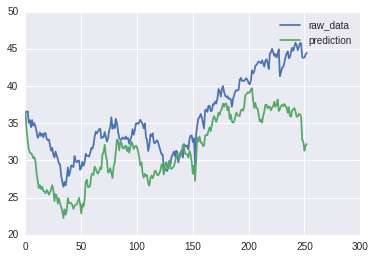

In [167]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.3896780014


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


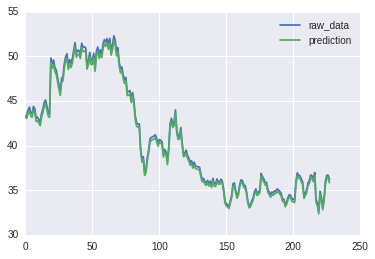

In [170]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.99999, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.633197069168


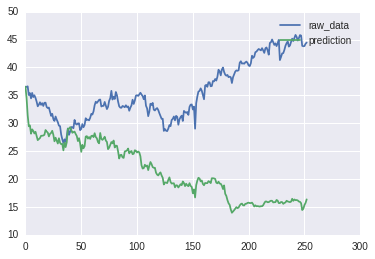

In [171]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.38224101067


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


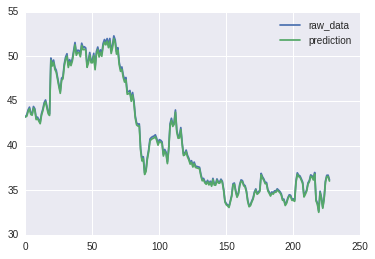

In [172]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=1.0, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.61528801918


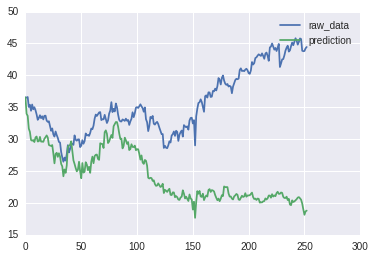

In [173]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Change the Connection Density

learning_time: 8.38301897049


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


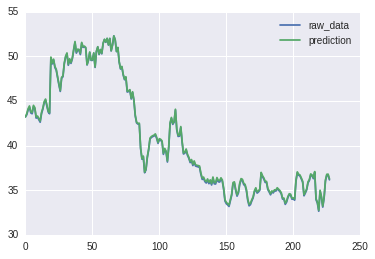

In [174]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.3)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.604793071747


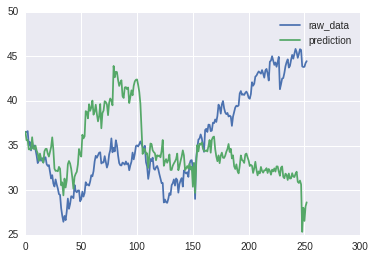

In [175]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.39111018181


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


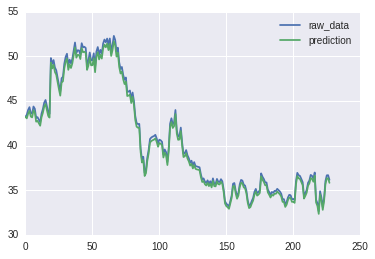

In [176]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.5)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.607350111008


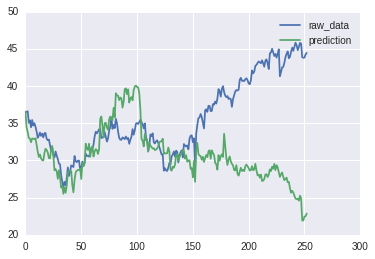

In [177]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.38104295731


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


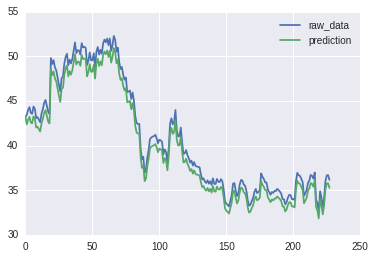

In [178]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.8)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.603152990341


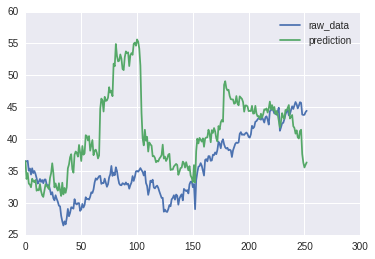

In [179]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.37986397743


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


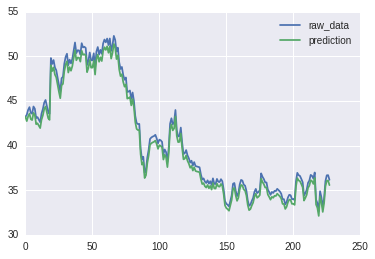

In [180]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=1.0)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.60712313652


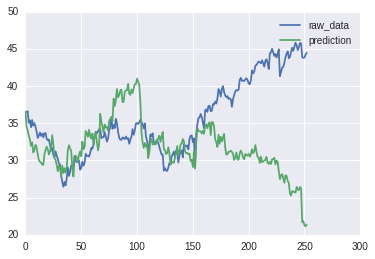

In [181]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# dense connected input network

In [183]:
class ESN5(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, 
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            W_in = np.random.uniform(low=alpha, high=alpha, size=(N_middle, N_in))
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.random.uniform(low=-alpha, high=alpha, size=N_middle)
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        # use log ratio data
        df_input = np.log(input_data[1:] / input_data[:-1])
        df_target = np.log(target_data[1:] / target_data[:-1])
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]])\
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[1.0, df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
           
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), df_input, middle_data]
        accumulated_price = np.cumprod(np.exp(np.dot(self.W_out, pre_out[start_time:].T).T))
        learned_data = target_data[start_time][0] * np.r_[1.0, accumulated_price]
        return learned_data
    
    def predict(self, input_data, sig=0):
        df_input = np.log(input_data[1:] / input_data[:-1])
        output_data = []
        N_data = len(df_input)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[1.0, df_input[i], new_m])
            middle = new_m
            output_data.append(output)
        output_data = np.exp(np.array(output_data).T[0])
        accumulated_price = np.cumprod(output_data)
        return np.r_[1.0, accumulated_price]

learning_time: 8.38368916512


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


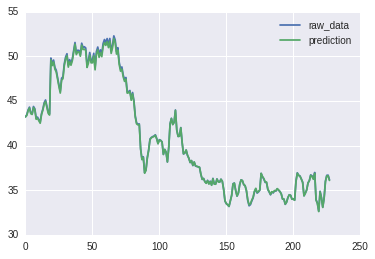

In [184]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN5(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.641716003418


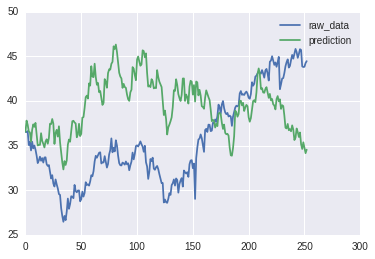

In [185]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 8.36837410927


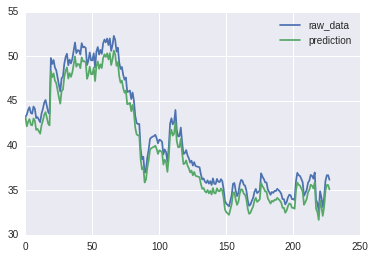

In [186]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN5(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.9, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.605145215988


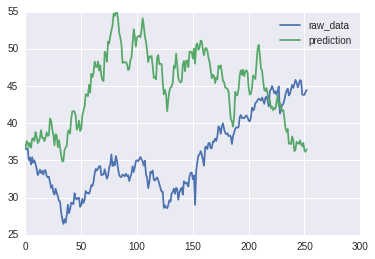

In [187]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.38132596016


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


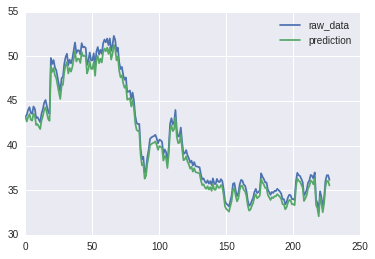

In [188]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN5(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.999, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.603304862976


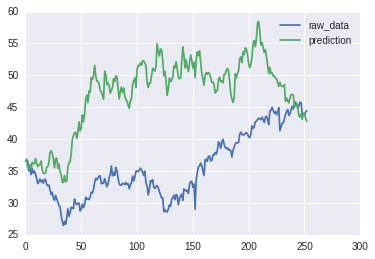

In [189]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.37526702881


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


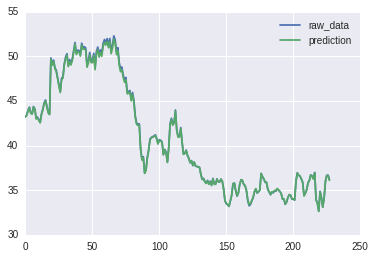

In [190]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN5(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.3)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.616378068924


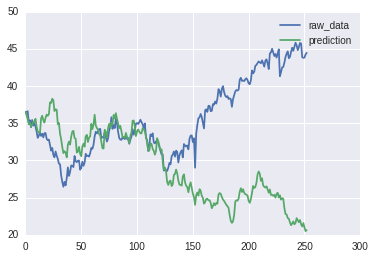

In [191]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.38844013214


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


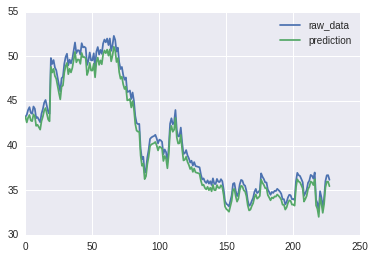

In [192]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN5(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.5)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.61850810051


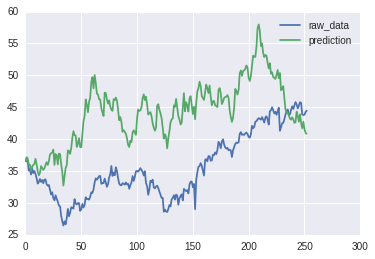

In [193]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.37964987755


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


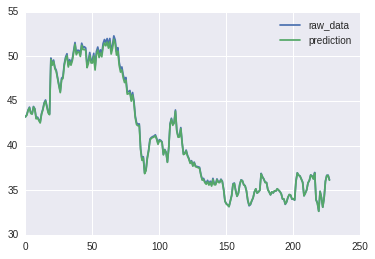

In [194]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN5(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.8)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.609113931656


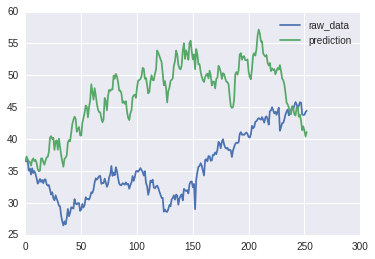

In [195]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 8.37937998772


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


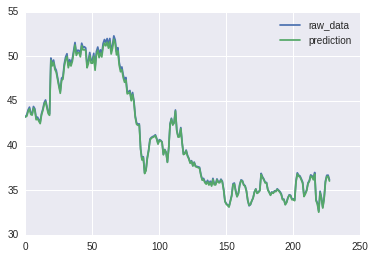

In [196]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN5(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=1.0)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.60560798645


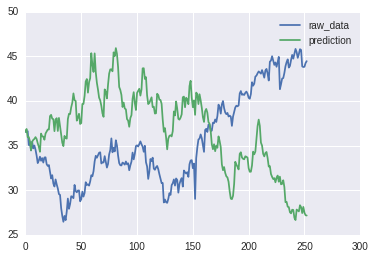

In [197]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

It looks that certain stocks affect predcition too much. 

I will consider normalization.

In [232]:
from scipy.linalg import sqrtm

class ESN6(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, 
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            W_in = np.random.uniform(low=alpha, high=alpha, size=(N_middle, N_in))
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.random.uniform(low=-alpha, high=alpha, size=N_middle)
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
    def normalization(self, data):
        dev = np.sqrt(np.var(data))
        mean = np.mean(data)
        return (data - mean) / dev, mean, dev
    
    def whitening(self, data):
        cov_root = sqrtm(np.cov(data.T))
        mean = np.mean(data, axis=0)
        return np.dot(np.linalg.inv(cov_root), (data - mean).T).T, mean, cov_root
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        #target.shape = (N_data), input_data = (N_data, N_stocks)
        # use log ratio data
        df_input_tilde = np.log(input_data[1:] / input_data[:-1])
        df_input, mean_ipt, dev_ipt = self.whitening(df_input_tilde)
        df_target_tilde = np.log(target_data[1:] / target_data[:-1])
        df_target, mean_tgt, dev_tgt = self.normalization(df_target_tilde.T[0])
        df_target = np.array([df_target]).T
        #keep deviance and mean for prediction
        self.input_mean = mean_ipt
        self.input_dev = dev_ipt
        self.output_mean = mean_tgt
        self.output_dev = dev_tgt
        
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]])\
                + np.dot(self.W_middle, middle)
                )\
                + sig * np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[1.0, df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
           
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1)\
                + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), df_input, middle_data]
        modified_out = self.output_dev * np.dot(self.W_out, pre_out[start_time:].T).T\
            + self.output_mean
        accumulated_price = np.cumprod(np.exp(modified_out))
        learned_data = target_data[start_time] * np.r_[1.0, accumulated_price]
        return learned_data
    
    def predict(self, input_data, sig=0):
        df_input_tilde = np.log(input_data[1:] / input_data[:-1])
        df_input = np.dot(np.linalg.inv(self.input_dev), (df_input_tilde - self.input_mean).T).T
        N_data = len(df_input)
        #initalization
        middle = self.middle.copy()
        output_data = []
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[1.0, df_input[i], new_m])
            middle = new_m
            output_data.append(output)
        output_data_tilde = np.exp((self.output_dev * np.array(output_data) + self.output_mean).T)
        accumulated_price = np.cumprod(output_data_tilde)
        return np.r_[1.0, accumulated_price]

learning_time: 10.4438788891


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


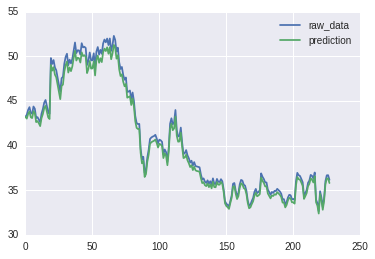

In [245]:
import time

T = len(input_data)
N_middle = T *5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.07905292511


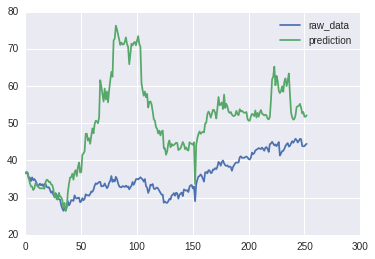

In [246]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 10.4563200474


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


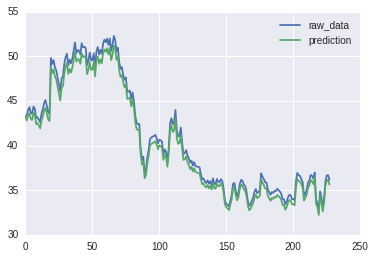

In [247]:
import time

T = len(input_data)
N_middle = T *5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.9, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.08017706871


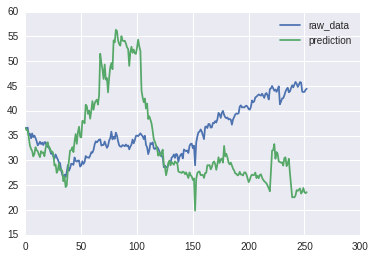

In [248]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 10.3170559406


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


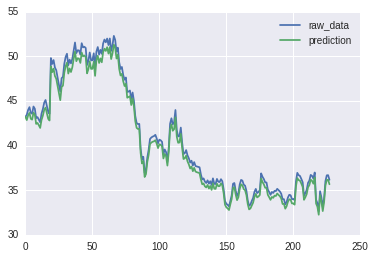

In [249]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.99, dense=0.1)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.0735669136


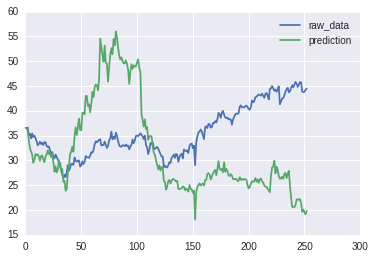

In [250]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 10.4262449741


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


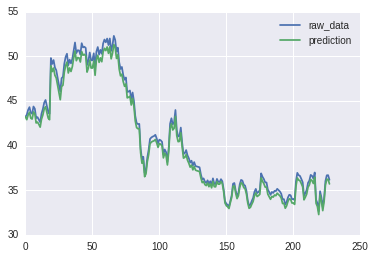

In [251]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.3)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.0754301548


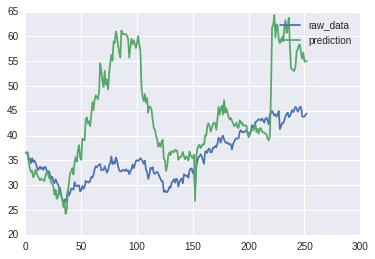

In [252]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 10.4463129044


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


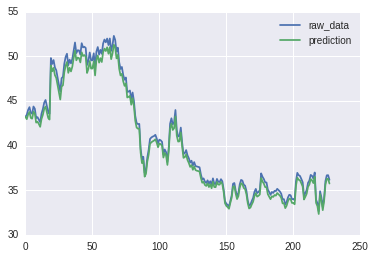

In [253]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.5)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.07395005226


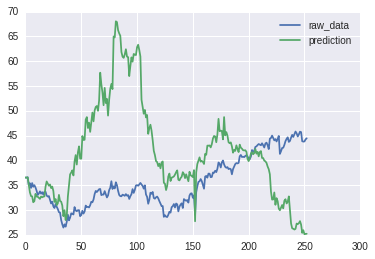

In [254]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 10.5918779373


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


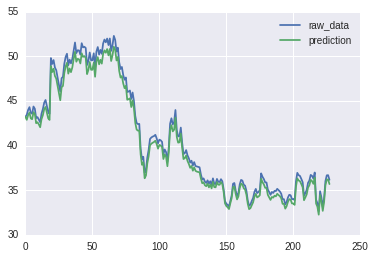

In [255]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.8)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.07539391518


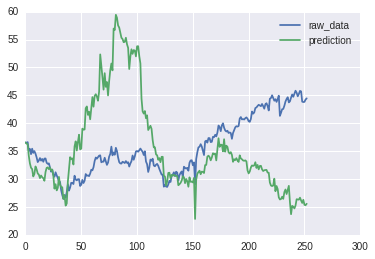

In [256]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 10.4149010181


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:115: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


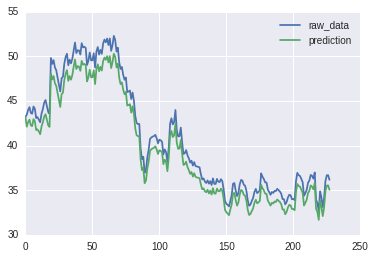

In [257]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=1.0)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.07434678078


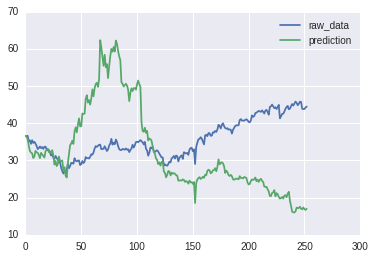

In [258]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


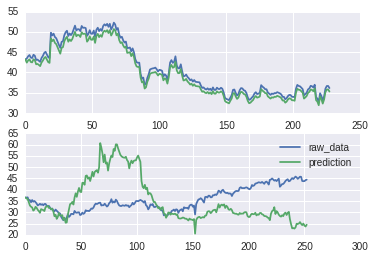

In [263]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN6(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.99, dense=0.5)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, target_data=target_data, 
                           start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()

In [264]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

class DLR(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, r=1.0, scale=0.8,
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            r (float): the value of connections
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(N_middle - 1):
                W_middle[i + 1][i] = r
            """
            #normalization
            print (W_middle)
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            print (np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
            """
        self.W_middle = W_middle
        
        if W_in is None:
            W_in = np.random.uniform(low=-1.0, high=1.0, size=(N_middle, N_in))
        self.W_in = W_in
        
    def normalization(self, data):
        dev = np.sqrt(np.var(data, axis=0))
        mean = np.mean(data, axis=0)
        return (data - mean) / dev, mean, dev
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2):
        # use log ratio data
        df_input_tilde = np.log(input_data[1:] / input_data[:-1])
        df_input, mean_ipt, dev_ipt = self.normalization(df_input_tilde)
        df_target_tilde = np.log(target_data[1:] / target_data[:-1])
        df_target, mean_tgt, dev_tgt = self.normalization(df_target_tilde)
        #keep deviance and mean for prediction
        self.input_mean = mean_ipt
        self.input_dev = dev_ipt
        self.output_mean = mean_tgt
        self.output_dev = dev_tgt
        
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, df_input[i])\
                + np.dot(self.W_middle, middle)
                )
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
           
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[df_input, middle_data]
        modified_out = self.output_dev * np.dot(self.W_out, pre_out[start_time:].T).T + self.output_mean
        accumulated_price = np.cumprod(np.exp(modified_out))
        learned_data = target_data[start_time] * np.r_[1.0, accumulated_price]
        return learned_data
    
    def predict(self, input_data, sig=0):
        df_input_tilde = np.log(input_data[1:] / input_data[:-1])
        df_input = (df_input_tilde - self.input_mean) / self.input_dev
        N_data = len(df_input)
        #initalization
        middle = self.middle.copy()
        output_data = []
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, df_input[i]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[df_input[i], new_m])
            middle = new_m
            output_data.append(output)
        output_data_tilde = np.exp((self.output_dev * np.array(output_data) + self.output_mean).T)
        accumulated_price = np.cumprod(output_data_tilde)
        return np.r_[1.0, accumulated_price]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:96: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 8.16679096222
prediction time: 0.616535902023


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


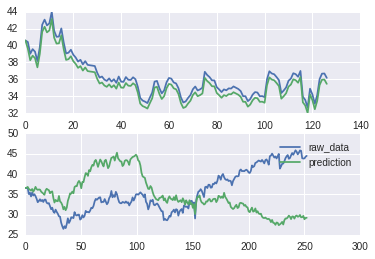

In [271]:
import time
import matplotlib.pyplot as plt

T = len(input_data)
N_middle = T * 5
esn = DLR(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, r=0.5)
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:96: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 7.99578785896
prediction time: 0.611900091171


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


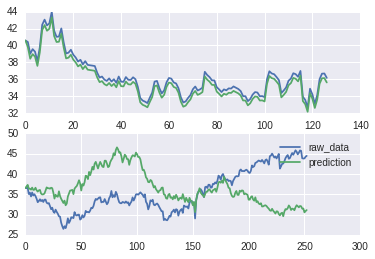

In [272]:
import time
import matplotlib.pyplot as plt

T = len(input_data)
N_middle = T * 5
esn = DLR(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, r=0.8)
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:96: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 7.98460006714
prediction time: 0.612401008606


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


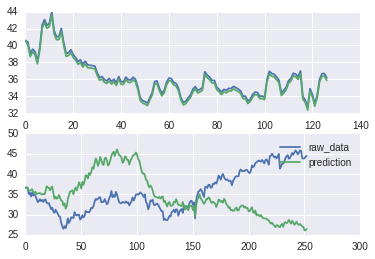

In [273]:
import time
import matplotlib.pyplot as plt

T = len(input_data)
N_middle = T * 5
esn = DLR(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, r=1.0)
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()